## Import libraries and dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Housing.csv')

In [3]:
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [4]:
df.isnull().sum()
# No missing values in the dataset

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

In [40]:
# Features
X = df.drop(['price'], axis=1)
# Labels
y = df['price'].values.reshape(-1,1)

## Data preprocessing

In [41]:
# Split the dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [42]:
# Encoding categorical labels & apply scaling
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

In [43]:
# Categorical columns
columns_to_encode = ['mainroad','guestroom','basement','hotwaterheating','airconditioning','prefarea','furnishingstatus']
# Numeric columns
numeric_cols = ['area','bedrooms','bathrooms','stories','parking']

preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), numeric_cols),
        ('encoder', OneHotEncoder(sparse_output=False), columns_to_encode)
    ],
    remainder='passthrough'
)

transformed_data_train = preprocessor.fit_transform(X_train)
transformed_data_test = preprocessor.transform(X_test)

ohe = preprocessor.named_transformers_['encoder']
ohe_feature_names = ohe.get_feature_names_out(columns_to_encode)
all_columns = numeric_cols + list(ohe_feature_names)

X_train = pd.DataFrame(transformed_data_train, columns=all_columns)
X_test = pd.DataFrame(transformed_data_test, columns=all_columns)

In [44]:
from sklearn.preprocessing import StandardScaler

# Scale y_train and y_test
y_scaler = StandardScaler()

# Fit on training targets only
y_train = y_scaler.fit_transform(y_train)
y_test = y_scaler.transform(y_test)

## Train model

In [45]:
from sklearn.svm import SVR

In [73]:
svr_rbf = SVR(kernel = 'linear', C=0.1, epsilon=0.1)

y_train = y_train.ravel()
y_test = y_test.ravel()
svr_rbf.fit(X_train, y_train)

y_train_pred = svr_rbf.predict(X_train)

In [58]:
from sklearn.model_selection import GridSearchCV

params = {
    'kernel': ['rbf', 'poly', 'linear'],
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.5, 1],
}

grid = GridSearchCV(svr_rbf, params, cv=5)
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)

Best params: {'C': 0.1, 'epsilon': 0.1, 'kernel': 'linear'}


## Evaluate model

In [74]:
from sklearn.metrics import r2_score

In [75]:
print(f'Score on train data: {svr_rbf.score(X_train, y_train)} Score on test data: {svr_rbf.score(X_test, y_test)}')

Score on train data: 0.680212843882215 Score on test data: 0.6319734121336045


In [76]:
y_test_pred = svr_rbf.predict(X_test)

print(r2_score(y_test, y_test_pred))


0.6319734121336045


## Plot

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

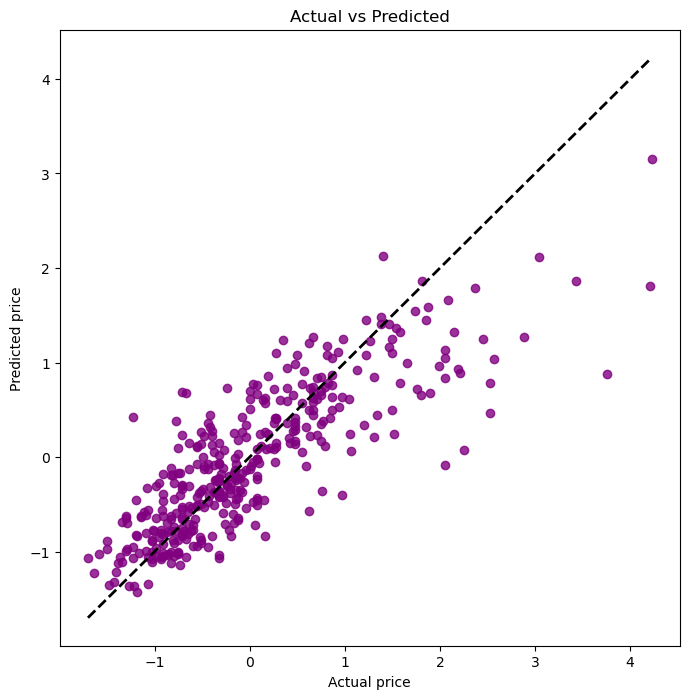

In [78]:
plt.figure(figsize=(8,8))
plt.scatter(y_train, y_train_pred, alpha=0.8, color='purple')
plt.xlabel('Actual price')
plt.ylabel('Predicted price')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
plt.title('Actual vs Predicted')
plt.show()

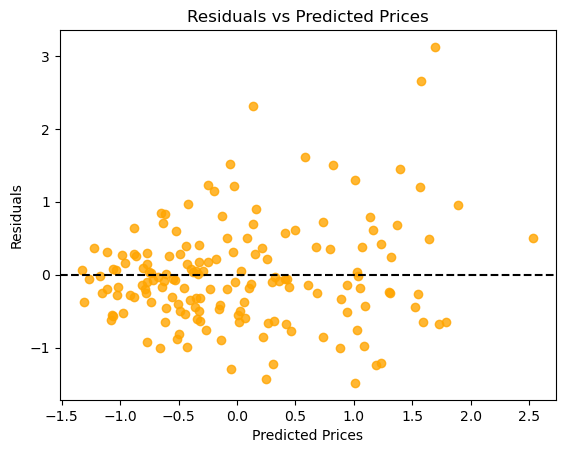

In [79]:
residuals = y_test - y_test_pred
plt.scatter(x=y_test_pred, y=residuals, alpha= 0.8, color='orange')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Prices')
plt.show()

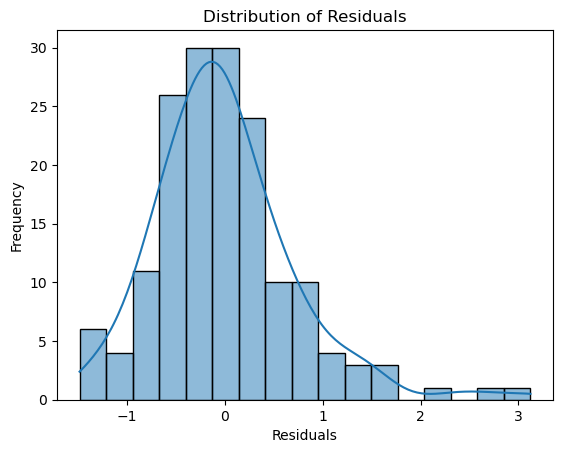

In [80]:
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

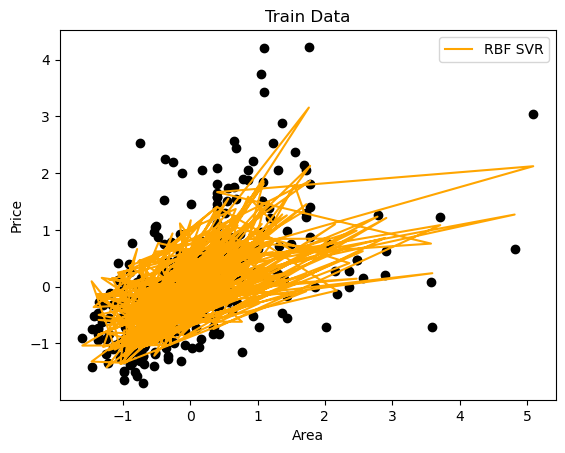

In [81]:
#### Visualization ####
plt.scatter(X_train['area'], y_train, color='black')
plt.plot(X_train['area'], y_train_pred, color = 'orange', label = 'RBF SVR')
plt.legend()
plt.xlabel('Area')
plt.ylabel('Price')
plt.title('Train Data')
plt.show()

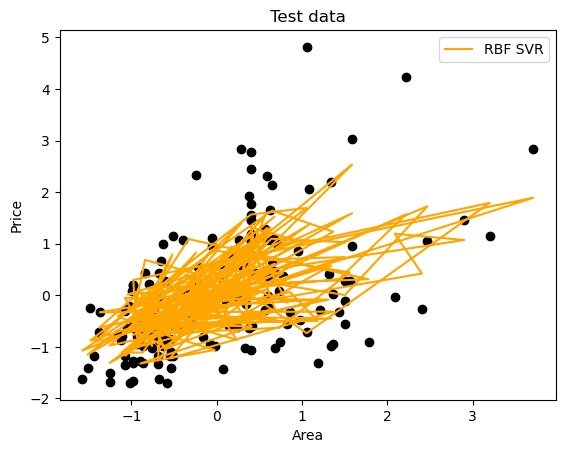

In [82]:
plt.scatter(X_test['area'], y_test, color='black')
plt.plot(X_test['area'], y_test_pred, color = 'orange', label = 'RBF SVR')
plt.legend()
plt.xlabel('Area')
plt.ylabel('Price')
plt.title('Test data')
plt.show()

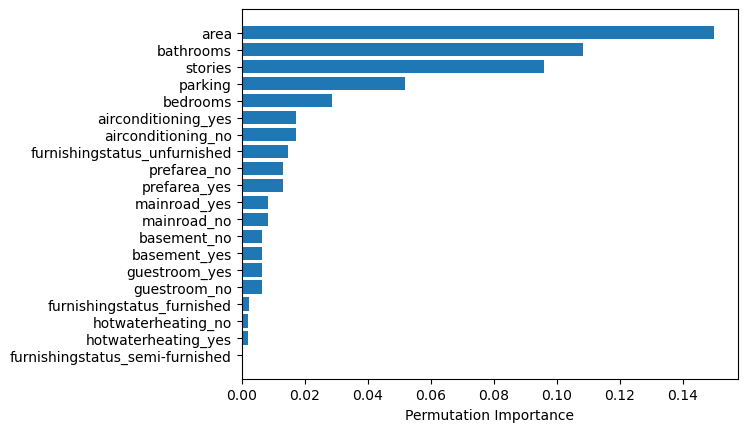

In [21]:
from sklearn.inspection import permutation_importance

result = permutation_importance(svr_rbf, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()

import matplotlib.pyplot as plt
plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx])
plt.yticks(range(len(sorted_idx)), [X_train.columns[i] for i in sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()